## $T_2$ Dephasing with Non-Markovian Noise
In this notebook, we show the effect of non-Markovian noise sources on qubit
coherence and their implementation in qopt. In terms of noise spectral densities
(NSD), these noise sources are characterized by non-trivial frequency
dependencies. While Markovian (or white) noise has a flat NSD, a typical
frequency behaviour of a non-Markovian SND is described for example by a power
law (referred to as colored noise).

We will demonstrate the effect of such a noise source based on Hamiltonian
motivated by the computational states of a singlet-triplet spin qubit with
basis $\{|S \rangle, |T_0 \rangle \}$. The basis states correspond to the spin
singlet and triplet zero states

\begin{align}
|S \rangle = \frac{1}{\sqrt{2}} \left( |\uparrow \downarrow \rangle
- |\downarrow \uparrow \rangle \right) \\
|T_0 \rangle = \frac{1}{\sqrt{2}} \left( |\uparrow \downarrow \rangle
+ |\downarrow \uparrow \rangle \right)
\end{align}

where $|S \rangle$ is defined as out $|0 \rangle$ state.

The Hamiltonian we employ is
\begin{align}
H = \frac{J(\varepsilon + \delta \varepsilon)}{2} \sigma_z +
\frac{\Delta B_z}{2} \sigma_x.
\end{align}

Here, $J$ is the exchange coupling between the involved spins controled by an
control parameter $\varepsilon$. $\Delta B_z$ describes a magnetic field
difference between the two spins. $\delta \varepsilon$ is noise on the control
parameter whose one-sided NSD we assume to follow $S_{\varepsilon}(f) = S_0/f$.

A common approximation for the exchange coupling that we will use is
$J(\varepsilon) = J_0 e^{\varepsilon / \varepsilon_0}$.

As we are dealing with correlated noise sources here, we cannot use the
Lindblad master equation but perform Monte Carlo simulations.
If we wanted to optimize control pulses, we would use generalized filter
functions for the calculation of infidelities.
Furthermore, as
our noise acts on a control parameter instead of a control amplitude, we
setup our solver with the according qopt solver class that incorporates this
usecase.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from qopt.matrix import DenseOperator
from qopt.solver_algorithms import SchroedingerSMCControlNoise
from qopt.amplitude_functions import CustomAmpFunc
from qopt.noise import NTGColoredNoise

pauli_x, pauli_z = DenseOperator.pauli_x(), DenseOperator.pauli_z()

np.random.seed(0)

S_0 = 1e-3
n_traces = 1  # The stored data was simulated with 500 traces. We plot
# the stored data and calculate only dummy values to comply with computational
# time budget

time_step = 0.1

delta_Bz = np.pi / 2
J_0 = 1
eps_0 = 1

def exchange_coupling(ctrl_param):
    return J_0 * np.exp(ctrl_param / eps_0)
    
exchange_coupling_ampl_fctn = CustomAmpFunc(
    value_function=exchange_coupling,
    derivative_function=None
)

def pink_spectrum(f):
    
    return S_0 / f
    
def average_monte_carlo_traces(solver, initial_state, measurement_state):
    
    propagators = solver.forward_propagators_noise
    probabilities = np.zeros(n_traces)
    
    for i in range(n_traces):
        final_state = propagators[i][-1] * initial_state
        probabilities[i] = np.abs(
            (measurement_state.dag() * final_state)[0,0]) ** 2

    return np.mean(probabilities)
    

### Free Induction Decay (FID)
The effect of $1/f$ noise becomes apparent when performing an FID. Starting in
the $|0 \rangle$ state, the procedure consists of two $X_{\pi/2}$ pulses that
are intercepted by a waiting period of lenth $\tau$. During the latter, the
qubit precesses around the z-axis with frequency $J$ and is sensitive to noise
on $\varepsilon$. At the end, the probability of the $| T_0 \rangle$ (or the
$|S \rangle$) state is measured which reveals an approximately Gaussian
$T_2^*$ decay following

\begin{align}
P(T_0) = \langle |\langle T_0 | \psi_f \rangle |^2 \rangle_{\delta
\varepsilon} \propto e^{-(\tau / T_2^*)^2} %*
\end{align}

where $|\psi_f(\tau) \rangle$ is the state after a FID sequence with waiting
time $\tau$ and $\langle \cdot \rangle_{\delta \varepsilon}$ is the average
over an enseble of noise traces.

In our simulation we use an idealistic pulse with vanishing exchange coupling
$J$ during the $X_{\pi/2}$ rotation. This is achieved by setting $\varepsilon$
to a large negative value. The $X_{\pi/2}$ rotation is mediated by $\Delta
B_z$.

To solely focus on noise related effects, we let $\Delta B_z$ vanish during the
precession periods. This is done by setting it to zero in the drift
Hamiltonian. Alternatively, we could use a $\Delta B_z$ that is negligible
with respect to the pressesion frequency. This would result in much longer
pulse sequences increasing the computation time drastically.

Another important consideration to be made when constructing the noise trace
generator is to specify the $\texttt{low_frequency_extention_ratio}$ parameter.
This will artificially increase the sequence's length during the generation of
noise traces by multiplying with the specifed value. As the low-frequency
cut-off of the noise spectrum is determined by the sequence duration, the
cut-off frequency is decreased. In this way, we can include noise that is
already quasi-static with respect to $\tau$ but still fluctuates on comparable
time scales. We chose a factor of 500 as the $T_2^*$-time roughly converges at
this point.

The computational time budget of readthedocs does not allow us to compute the
proper simulation remotely. Therefore we only use a single noise trace for the
calculation of dummy values and plot data calculated with 500 noise traces.

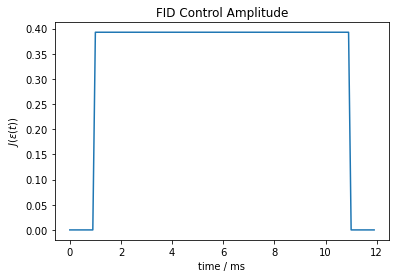

In [2]:
X_pi_half_time = np.pi / 2 / delta_Bz
n_steps_X_pi_half = int(X_pi_half_time / time_step)

# Control parameter during X_pi/2 pulse
eps_idle = -20  

# Control param. resulting in precession freq. J(eps_work) = pi / 8
eps_work = eps_0 * np.log(np.pi / 8 / J_0)  

def fid_pulse(tau):
    """
    Generates the control pulse (epsilon) for the FID sequence.
    """
    n_steps_tau = int(tau / time_step)
    n_steps_pulse = 2 * n_steps_X_pi_half + n_steps_tau
    
    ctrl_parameter = np.zeros((n_steps_pulse,1)) + eps_idle
    
    ind_start, ind_end = n_steps_X_pi_half, n_steps_X_pi_half + n_steps_tau
    ctrl_parameter[ind_start:ind_end] = eps_work

    return ctrl_parameter


def create_monte_carlo_solver(tau, pulse_function):
    
    control_pulse = pulse_function(tau)
    n_time_steps = len(control_pulse)
    
    active_dBz = np.where(control_pulse == eps_idle, 1, 0).flatten()

    h_drift = [0.5 * delta_Bz * active * pauli_x  for active in active_dBz]

    ntg_pink = NTGColoredNoise(
        n_samples_per_trace=n_time_steps,
        noise_spectral_density=pink_spectrum,
        dt=time_step,
        n_traces=n_traces,
        low_frequency_extension_ratio=500
    )
    
    solver = SchroedingerSMCControlNoise(
        h_drift=h_drift,
        h_ctrl=[.5 * pauli_z,],
        tau=time_step * np.ones(n_time_steps),
        noise_trace_generator=ntg_pink,
        amplitude_function=exchange_coupling_ampl_fctn
    )
    
    solver.set_optimization_parameters(control_pulse)
    
    return solver

sample_solver = create_monte_carlo_solver(10, fid_pulse)
sample_amplitude = sample_solver._ctrl_amps

plt.plot(np.arange(len(sample_amplitude)) * time_step, sample_amplitude)
plt.xlabel("time / ms")
plt.ylabel("$J(\\varepsilon(t))$")
plt.title("FID Control Amplitude")
plt.show()

In [3]:
precession_times = np.arange(0,100,3)

initial_state = DenseOperator(np.array([[1], [0]]))
measurement_state = DenseOperator(np.array([[0], [1]]))

probabilities_fid = np.zeros(len(precession_times))

for i, tau in enumerate(precession_times):
    
    solver = create_monte_carlo_solver(tau, fid_pulse)
    probabilities_fid[i] = average_monte_carlo_traces(
        solver, initial_state, measurement_state)
    

In [4]:
# np.save(r"..\stored\precession_times_1", precession_times,)
# np.save(r"..\stored\probabilities_fid_1", probabilities_fid,)

In [5]:
precession_times_loaded = np.load(r"..\stored\precession_times_1.npy")
probabilities_fid_loaded = np.load(r"..\stored\probabilities_fid_1.npy")

In [6]:
def T2_star_decay(t, T2, alpha):
    omega = exchange_coupling(eps_work)
    return 0.5 * (1 + np.exp(-(t / T2)**alpha) * np.cos(omega * t))

popt, cov = curve_fit(T2_star_decay, precession_times_loaded,
                      probabilities_fid_loaded, p0=[50, 2])
print("Fit parameters: ", popt)

precession_times_fine = np.linspace(min(precession_times_loaded),
                                    max(precession_times_loaded), 500)

Fit parameters:  [46.70488819  1.96333833]


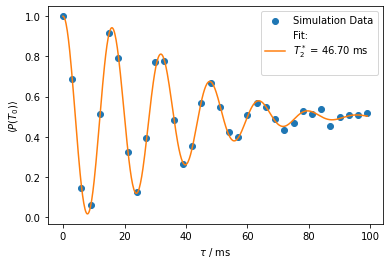

In [7]:
plt.scatter(precession_times_loaded, probabilities_fid_loaded,
            label="Simulation Data")
plt.plot(precession_times_fine, T2_star_decay(precession_times_fine, *popt),
         color="tab:orange",
         label="Fit: \n$T_2^*$ = {:.2f} ms\n ".format(popt[0]))
plt.xlabel("$\\tau$ / ms")
plt.ylabel("$\langle P(T_0) \\rangle$")
plt.legend()
plt.show()

The simulated $T_2^*$ time lies in the expected order of magnitude when
approximated by
$(T_2^*)^2 = \frac{2}{S_0 (dJ/d\varepsilon)^2\ln\frac{T_{meas}}{2\pi \tau}}$
(c.f., supplement of
[Dial et al., PRL 110 (2013)](https://doi.org/10.1103/PhysRevLett.110.146804))
leading to $T_2^* \approx 54~\text{ms}$ for our parameters. We approximated the
measurement time by the number of noise traces
$T_{meas} \approx n_{traces} \tau$.
A slight deviation from the Gaussian decay is caused by the finite
frequency cutoff, the non-linearity of $J$ and stochastic fluctuations.

### Spin-Echo
The coherence time can be increased by intercepting periods, during which the
qubit is susceptible to noise, with appropriate echo pulses. For example, a
$X_{\pi}$ pulse can be placed in the middle of the free precession period of
the FID sequence. This allows to refocus over- or underrotation of the qubit
that occurred due to noise that is quasi-static with respect to the precession
time $\tau$.

In the noise-less case, the qubit would return to its initial position after
the pulse sequence. We therfore expect the average probability of the $| S
\rangle$ state to decrease as $\langle P(S) \rangle = \frac{1}{2} \left(1 +
e^{-(t/T_{2,\text{echo}})^2} \right)$.

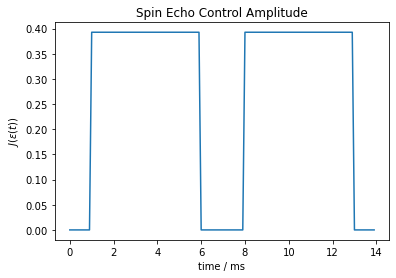

In [8]:
def echo_pulse(tau):
    
    n_steps_half_tau = int(tau / 2 / time_step)
    n_steps_pulse = 4 * n_steps_X_pi_half + 2 * n_steps_half_tau

    ctrl_parameter = np.zeros((n_steps_pulse,1)) + eps_idle

    ind_start = n_steps_X_pi_half
    ind_end = ind_start + n_steps_half_tau
    ctrl_parameter[ind_start:ind_end] = eps_work
    
    ind_start = 3 * n_steps_X_pi_half + n_steps_half_tau
    ind_end = ind_start + n_steps_half_tau
    ctrl_parameter[ind_start:ind_end] = eps_work

    return ctrl_parameter

echo_sample_solver = create_monte_carlo_solver(10, echo_pulse)
echo_sample_amplitudes = echo_sample_solver._ctrl_amps
plt.plot(np.arange(len(echo_sample_amplitudes)) * time_step,
         echo_sample_amplitudes)
plt.xlabel("time / ms")
plt.ylabel("$J(\\varepsilon(t))$")
plt.title("Spin Echo Control Amplitude")
plt.show()

In [9]:
precession_times_2 = np.arange(0,100,3)

In [10]:
probabilities_echo = np.zeros(len(precession_times_2))

measurement_state_echo = initial_state

for i, tau in enumerate(precession_times_2):
    
    solver = create_monte_carlo_solver(tau, echo_pulse)
    probabilities_echo[i] = average_monte_carlo_traces(solver, initial_state,
                                                       measurement_state_echo)
    

In [11]:
# np.save(r"..\stored\precession_times_2", precession_times_2,)
# np.save(r"..\stored\probabilities_echo_2", probabilities_echo,)

In [12]:
precession_times_2_loaded = np.load(r"..\stored\precession_times_2.npy")
probabilities_echo_loaded = np.load(r"..\stored\probabilities_echo_2.npy")


In [13]:
def T2_echo_decay(t, T2_echo, alpha):
    return 0.5 * (1 + np.exp(-(t / T2_echo) ** alpha))
    
popt_echo, cov_echo_al = curve_fit(T2_echo_decay, precession_times_2_loaded,
                                   probabilities_echo_loaded, p0=[136, 2])
print("Fit parameters: ", popt_echo)


Fit parameters:  [135.30109118   1.90271031]


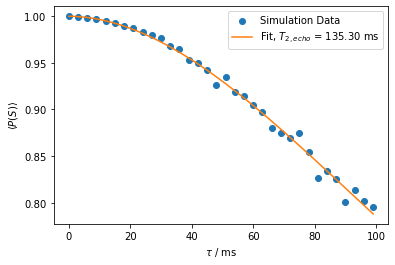

In [14]:
plt.scatter(precession_times_2_loaded, probabilities_echo_loaded,
            label="Simulation Data")
plt.plot(precession_times_fine, T2_echo_decay(
         precession_times_fine, *popt_echo),
         color="tab:orange",
         label="Fit, $T_{2,echo}$ = " + "{:.2f} ms".format(popt_echo[0]))
plt.xlabel("$\\tau$ / ms")
plt.ylabel("$\langle P(S) \\rangle$")
plt.legend()
plt.show()

We see that the spin echo increases the coherence time in comparison to free
decay. Also, the coherence time matches the order of magnitude by the
theoretically predicted (c.f., above mentioned reference)

\begin{align}
T_{2,echo}^{1+\alpha} = \frac{1}{S_0 (dJ/d\varepsilon)^2 (2-2^{-\alpha+1})
\Gamma(-1-\alpha) \sin(\pi \alpha/2)}
\end{align}

for $\alpha = 1$ leading to $T_{2,echo} \approx 137~\text{ms}$.

We see that the spin echo increases the coherence time in comparison to free
decay. Also, the coherence time matches the order of magnitude by the
theoretically predicted (c.f., above mentioned reference)

\begin{align}
T_{2,echo}^{1+\alpha} = \frac{1}{S_0 (dJ/d\varepsilon)^2 (2-2^{-\alpha+1})
\Gamma(-1-\alpha) \sin(\pi \alpha/2)}
\end{align}

for $\alpha = 1$ leading to $T_{2,echo} \approx 137~\text{ms}$.

In [15]:
probabilities_echo = np.zeros(len(precession_times_2))

measurement_state_echo = initial_state

for i, tau in enumerate(precession_times_2):
    
    solver = create_monte_carlo_solver(tau, echo_pulse)
    probabilities_echo[i] = average_monte_carlo_traces(solver, initial_state,
                                                       measurement_state_echo)
    

In [16]:
# np.save(r"..\stored\precession_times_2", precession_times_2,)
# np.save(r"..\stored\probabilities_echo_2", probabilities_echo,)

In [17]:
precession_times_2_loaded = np.load(r"..\stored\precession_times_2.npy")
probabilities_echo_loaded = np.load(r"..\stored\probabilities_echo_2.npy")


In [18]:
def T2_echo_decay(t, T2_echo, alpha):
    return 0.5 * (1 + np.exp(-(t / T2_echo) ** alpha))
    
popt_echo, cov_echo_al = curve_fit(T2_echo_decay, precession_times_2_loaded,
                                   probabilities_echo_loaded, p0=[136, 2])
print("Fit parameters: ", popt_echo)


Fit parameters:  [135.30109118   1.90271031]


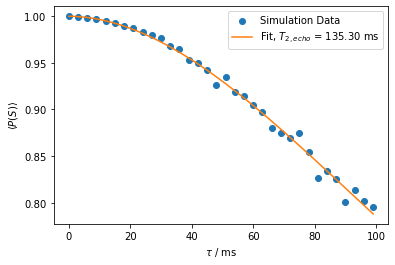

In [19]:
plt.scatter(precession_times_2_loaded, probabilities_echo_loaded,
            label="Simulation Data")
plt.plot(precession_times_fine, T2_echo_decay(
         precession_times_fine, *popt_echo),
         color="tab:orange",
         label="Fit, $T_{2,echo}$ = " + "{:.2f} ms".format(popt_echo[0]))
plt.xlabel("$\\tau$ / ms")
plt.ylabel("$\langle P(S) \\rangle$")
plt.legend()
plt.show()

We see that the spin echo increases the coherence time in comparison to free
decay. Also, the coherence time matches the order of magnitude by the
theoretically predicted (c.f., above mentioned reference)

\begin{align}
T_{2,echo}^{1+\alpha} = \frac{1}{S_0 (dJ/d\varepsilon)^2 (2-2^{-\alpha+1})
\Gamma(-1-\alpha) \sin(\pi \alpha/2)}
\end{align}

for $\alpha = 1$ leading to $T_{2,echo} \approx 137~\text{ms}$.